# Overlapping different models from the resulting kwargs

the plot produced here is scaled correctly, but has not the correct inclination wrt WCS;
it is the best way to compare two models nonetheless
reworked for the usm machines AND to use the new setting files

In [1]:
# import of standard python libraries
import numpy as np
import matplotlib.pyplot as plt
from lenstronomy.LensModel.lens_model import LensModel
import lenstronomy.Util.util as util
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Plots import plot_util
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import sys
import argparse

from tools import *
from get_res import *

In [ ]:
################################
present_program(sys.argv[0])
################################
parser = argparse.ArgumentParser(description="Overplot the convergence model with image positions")
parser.add_argument('SETTING_FILES',nargs=(2),default=[],help="setting file(s) to consider")
args = parser.parse_args()
setting_names =  args.SETTING_FILES

In [2]:
# f160 only as the first filter
result_file  = "/read_results_updated.data"
sig_up_file  = "/read_sigma_up.data"
sig_low_file = "/read_sigma_low.data"

backup_path    = "backup_results/" 
paths          = [get_savefigpath(st,backup_path) for st in setting_names]
sig_up_files   = [pth+sig_up_file for pth in paths] 
sig_low_files  = [pth+sig_low_file for pth in paths] 

filters     = [strip_setting_name(st) for st in setting_names]
filters_str = filters[0]+"_"+filters[1]

In [4]:
def rt_coord(coord_ra,coord_dec,transf_m):
    try:
        if len(coord_dec)!=len(coord_ra):
            raise ValueError("coord_ra and coord_dec must have the same lenght!")
    except:
        coord_ra,coord_dec = [coord_ra],[coord_dec]
    theta = -np.arcsin(transf_m[0][1])
    rot_matrix = np.array([[np.cos(theta),-np.sin(theta)],[-np.sin(theta),-np.cos(theta)]])
    
    inv_matrix = np.array([[-1,0],[0,-1]])
    if len(coord_ra)==1:
        return np.dot(np.dot([*coord_ra,*coord_dec],rot_matrix),inv_matrix)
    rt_ra,rt_dec = [] , []
    for ra,dec in zip(coord_ra,coord_dec):
        res = np.dot(np.dot([ra,dec],rot_matrix),inv_matrix)
        rt_ra.append(res[0])
        rt_dec.append(res[1])
    return np.array(rt_ra),np.array(rt_dec)

def find_new_rot(acoord,bcoord,creat_matr = False):
    dx = bcoord[0]-acoord[0]
    dy = bcoord[1]-acoord[1]
    intheta = np.arctan(dy/dx)
    theta = np.pi-(np.pi/2. - abs(intheta))*intheta/abs(intheta) 
    #theta = -(np.pi/2-intheta)
    if creat_matr==False:
        return theta
    else:
        return np.array([[np.cos(theta),-np.sin(theta)],[-np.sin(theta),-np.cos(theta)]])

    
def sigma_rot(ra,dec,sig_ra_up,sig_ra_down,sig_dec_up,sig_dec_down,ra0,dec0, rot_mat):

    ra_up   = [+sig_ra_up,0]
    ra_down = [-sig_ra_down,0]
    dec_up  = [0,+sig_dec_up]
    dec_down= [0,-sig_dec_down]

    x11,y11= rt_coord(*ra_up,rot_mat)   +rt_coord(ra-ra0,dec-dec0,rot_mat) 
    x12,y12= rt_coord(*ra_down,rot_mat) +rt_coord(ra-ra0,dec-dec0,rot_mat) 
    x21,y21= rt_coord(*dec_up,rot_mat)  +rt_coord(ra-ra0,dec-dec0,rot_mat) 
    x22,y22= rt_coord(*dec_down,rot_mat)+rt_coord(ra-ra0,dec-dec0,rot_mat) 
    
    return np.array([x11,y11]),np.array([x12,y12]),np.array([x21,y21]),np.array([x22,y22])


In [5]:
# Convert the lens parameters 
def conv_e12(e1,e2,transf_m):
    theta =  np.arcsin(transf_m[0][1]) #-1 cause "reflected" image
    #e1 = [(1-q)/(1+q)] cos2phi = alpha cos2phi
    #e2 = [(1-q)/(1+q)] sin2phi = alpha sin2phi
    alpha = np.sqrt(e1**2+e2**2)
    q = (1-alpha)/(1+alpha)
    phi=0.5 * np.arctan(e2/e1)
    phi_new= (phi-theta)
    e1_rot = alpha*np.cos(2*phi_new)
    e2_rot = alpha*np.sin(2*phi_new)
    return e1_rot,e2_rot




In [3]:
# lensing quantities
kw_setting = []

for i_set,sets in enumerate(setting_names):
    kw_set_i = {"name":filters[i_set]}
    lens_model_list = ['SIE']
    if check_if_CP(sets):
        lens_model_list = ['PEMD']
    lens_model_list = [*lens_model_list,'SIS','SHEAR_GAMMA_PSI']
    lens_model = LensModel(lens_model_list)

    wll = not check_if_SUB(sets) #with lens light model
    
    kwargs_result = get_kwres(sets,updated=True,backup_path=backup_path)["kwargs_results"]

    kwrg_lens_1 = {}
    kwrg_lens_1["theta_E"] = kwargs_result["theta_E_lens0"]
    kwrg_lens_1["e1"] = kwargs_result["e1_lens0"]
    kwrg_lens_1["e2"] = kwargs_result["e2_lens0"]
    if wll:
        kwrg_lens_1["center_x"] = kwargs_result["center_x_lens_light0"]
        kwrg_lens_1["center_y"] = kwargs_result["center_y_lens_light0"]

    else:
        kwrg_lens_1["center_x"] = kwargs_result["center_x_lens0"]
        kwrg_lens_1["center_y"] = kwargs_result["center_y_lens0"]

    if check_if_CP(sets):
        kwrg_lens_1["gamma"] = kwargs_result["gamma_lens0"]
        
    kwrg_lens_2 = {}
    kwrg_lens_2["theta_E"] = kwargs_result["theta_E_lens1"]
    if wll:
        kwrg_lens_2["center_x"] = kwargs_result["center_x_lens_light1"]
        kwrg_lens_2["center_y"] = kwargs_result["center_y_lens_light1"]

    else:
        kwrg_lens_2["center_x"] = kwargs_result["center_x_lens_light0"]
        kwrg_lens_2["center_y"] = kwargs_result["center_y_lens_light0"]

    kwrg_lens_3 = {}
    # TODO Patch to be improved
    if "fixed_shear" in sets or "fixedshear" in sets:
        st = get_setting_module(sets).setting()
        kwrg_lens_3["gamma_ext"] = st.lens_params[2][-1]["gamma_ext"]
    else:
        kwrg_lens_3["gamma_ext"] = kwargs_result["gamma_ext_lens2"]
    kwrg_lens_3["psi_ext"] = kwargs_result["psi_ext_lens2"]

    ra_image  = []
    dec_image = []
    for i in range(4):
        ra_image.append(kwargs_result["ra_image_"+str(i)] )
        dec_image.append(kwargs_result["dec_image_"+str(i)] )
    
    ra_image,dec_image = np.array(ra_image),np.array(dec_image)
    #kw_set_i["ra_image"]  = ra_image
    #kw_set_i["dec_image"] = dec_image
    
    
    setting = get_setting_module(sets).setting()
    
    in_x = np.array(setting.x_image)
    in_y = np.array(setting.y_image)
    in_lensx = np.array(setting.center_x)
    in_lensy = np.array(setting.center_y)
    in_pertx = np.array(setting.x_pert)
    in_perty = np.array(setting.y_pert)

    kw_set_i["in_data"]=[in_x,in_y,in_lensx,in_lensy,in_pertx,in_perty] 

    with open(sig_up_files[i_set],"rb") as f:
        sig_up  = pickle.load(f)
    with open(sig_low_files[i_set],"rb") as f:
        sig_low = pickle.load(f)

    
    sig_up_ra = []
    sig_up_dec = []
    sig_low_ra = []
    sig_low_dec = []
    for i in range(4):
        sig_up_ra.append(sig_up["ra_image_"+str(i)] )
        sig_up_dec.append(sig_up["dec_image_"+str(i)] )
        sig_low_ra.append(sig_low["ra_image_"+str(i)] )
        sig_low_dec.append(sig_low["dec_image_"+str(i)] )
    if not wll:
        sig_lens = [sig_low["center_x_lens0"],sig_up["center_x_lens0"],
                     sig_low["center_y_lens0"],sig_up["center_y_lens0"]]
        sig_pert = [sig_low["center_x_lens_light0"],sig_up["center_x_lens_light0"],
                     sig_low["center_y_lens_light0"],sig_up["center_y_lens_light0"]]
    else:
        sig_lens = [sig_low["center_x_lens_light0"],sig_up["center_x_lens_light0"],
                     sig_low["center_y_lens_light0"],sig_up["center_y_lens_light0"]]
        sig_pert = [sig_low["center_x_lens_light1"],sig_up["center_x_lens_light1"],
                     sig_low["center_y_lens_light1"],sig_up["center_y_lens_light1"]]


    Acoord = [ra_image[0],dec_image[0]]
    Bcoord = [ra_image[2],dec_image[2]]
    rot_matr = find_new_rot(Acoord,Bcoord,creat_matr=True)
    #kw_set_i["rot_matr"] = rot_matr

    ra,dec = rt_coord(ra_image-ra_image[0],dec_image-dec_image[0],rot_matr)

    kw_set_i["coord_im"] = [ra,dec]
    
    sig_i = []
    for i in range(len(sig_up_ra)):
        sig_i.append(sigma_rot(ra_image[i],dec_image[i],sig_up_ra[i],sig_low_ra[i], sig_up_dec[i],sig_low_dec[i],ra_image[0],dec_image[0], rot_matr) )
    kw_set_i["sig_im"] = sig_i

    lens_ra_rot,lens_dec_rot = rt_coord(kwrg_lens_1["center_x"]-ra_image[0],kwrg_lens_1["center_y"]-dec_image[0],rot_matr)
    pert_ra_rot,pert_dec_rot = rt_coord(kwrg_lens_2["center_x"]-ra_image[0],kwrg_lens_2["center_y"]-dec_image[0],rot_matr)

    #kw_set_i["coord_lens"] = lens_ra_rot,lens_dec_rot
    #kw_set_i["coord_pert"] = pert_ra_rot,pert_dec_rot
    
    sig_rt_lens_i = sigma_rot(kwrg_lens_1["center_x"],kwrg_lens_1["center_y"],*sig_lens,ra_image[0],dec_image[0],rot_matr) 
    sig_rt_pert_i = sigma_rot(kwrg_lens_2["center_x"],kwrg_lens_2["center_y"],*sig_pert,ra_image[0],dec_image[0],rot_matr)

    kw_set_i["sig_lens"] = sig_rt_lens_i
    kw_set_i["sig_pert"] = sig_rt_pert_i

    e1_rot,e2_rot = conv_e12(kwrg_lens_1["e1"],kwrg_lens_1["e2"],rot_matr)
    e1_rot,e2_rot = conv_e12(e1_rot,e2_rot,np.array([[-1,0],[0,-1]]))
    
    kwrg_lens_1["e1"],kwrg_lens_1["e2"]=e1_rot,e2_rot 
    kwrg_lens_1["center_x"],kwrg_lens_1["center_y"] = lens_ra_rot,lens_dec_rot
    kwrg_lens_2["center_x"],kwrg_lens_2["center_y"] = pert_ra_rot,pert_dec_rot
    
    theta =  np.arcsin(rot_matr[0][1]) #-1 cause "reflected" image
    kwrg_lens_3["psi_ext"] = kwrg_lens_3["psi_ext"] - theta

    kw_set_i["kw_lenses"]= [kwrg_lens_1,kwrg_lens_2,kwrg_lens_3]
    
    ##############
    # Source pos #
    ##############
    kw_source = load_whatever(get_savefigpath(sets)+"/read_source.data")
    source_ra,source_dec = kw_source["source_ra"][0],kw_source["source_dec"][0]
    source_ra_rot,source_dec_rot = rt_coord(source_ra-ra_image[0],source_dec-dec_image[0],rot_matr)
    kw_set_i["kw_source"] = [source_ra_rot,source_dec_rot]
    ############################
    kw_setting.append(kw_set_i)

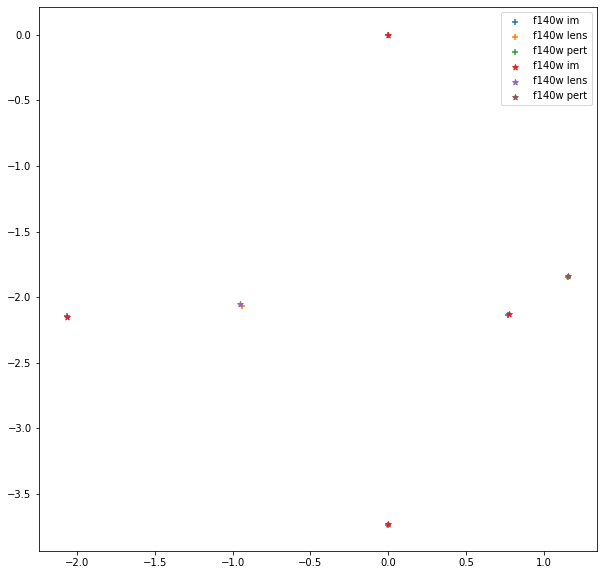

In [6]:
import matplotlib
def compare_pos(kw_sets,npix=10,savefig=None):
    f,ax =plt.subplots(1, 1, figsize=(npix,npix))
    matplotlib.rc('font', size=18)
    plt.title("Results from "+kw_sets[0]["name"]+" and "+kw_sets[1]["name"])

    col = [["red","tomato","chocolate","orange"],["forestgreen","lime","cyan","yellowgreen"]]
    lets = ["A","C","B","D"]
    for i,kwst in enumerate(kw_sets):
        flt = kwst["name"]
        """
        from conversion import * 
        # convert with respect to 1st setting
        im  = conv_radec_to_xy(setting_names[0],kwst["coord_im"][0],kwst["coord_im"][1])
        
        lns = conv_radec_to_xy(setting_names[0],kwst["kw_lenses"][0]["center_x"],kwst["kw_lenses"][0]["center_y"])
        prt = conv_radec_to_xy(setting_names[0],kwst["kw_lenses"][1]["center_x"],kwst["kw_lenses"][1]["center_y"])
        
        src = conv_radec_to_xy(setting_names[0],kwst["kw_source"][0],kwst["kw_source"][1]) 
        """
        im  = kwst["coord_im"][0],kwst["coord_im"][1]
        lns = kwst["kw_lenses"][0]["center_x"],kwst["kw_lenses"][0]["center_y"]
        prt = kwst["kw_lenses"][1]["center_x"],kwst["kw_lenses"][1]["center_y"]
        src = kwst["kw_source"][0],kwst["kw_source"][1]
        
        ax.scatter(*im,marker="o",label=flt+" im",c=col[i][0])
        for ii in range(len(im[0])):
            ax.text(im[0][ii]+.1,im[1][ii],lets[ii],c=col[i][0])
        ax.scatter(*lns,marker="+",label=flt+" lens",c=col[i][1])
        ax.text(lns[0],lns[1],"Lens",c=col[i][1])
        ax.scatter(*prt,marker="+",label=flt+" pert",c=col[i][2])
        ax.text(prt[0],prt[1],"Pert.",c=col[i][2])
        ax.scatter(*src,marker="x",label=flt+" source",c=col[i][3])
        ax.text(src[0],src[1],"Source",c=col[i][3])
        
    plt.legend()
    if savefig is None:
        plt.show()
    else:
        if type(savefig) is str:
            plt.savefig(savefig)
        else:# list of savefig
            for svfg in savefig:
                plt.savefig(svfg)
                
svfgs = []
for pth,flt in zip(paths,filters):
    svfgs.append(pth+"pos_"+filters_str+".png")
compare_pos(kw_setting,npix=15,savefig=svfgs)

In [8]:

class my_model_plot():
    def __init__(self,lens_model,kwargs_lens,ra_image,dec_image,npix=50, transf_matrix = np.array([[1,0],[0,1]]),ra_at_xy_0=0,dec_at_xy_0=0,  arrow_size=0.02):
        self._lensModel = lens_model
        self._ra_at_xy_0 = ra_at_xy_0
        self._dec_at_xy_0 = dec_at_xy_0
        self._coords = PixelGrid(npix,npix,transf_matrix,ra_at_xy_0,dec_at_xy_0)
        x_grid, y_grid = self._coords.pixel_coordinates
        self._x_grid = util.image2array(x_grid)
        self._y_grid = util.image2array(y_grid)
        self._frame_size = np.max(self._coords.width)
        self._arrow_size = arrow_size
        self._kwargs_lens=kwargs_lens
        self.ra_image = ra_image
        self.dec_image = dec_image
        self.transf_matrix = transf_matrix
        
    def my_convergence_plot(self,ax, text='Convergence', v_min=None, v_max=None,
                         font_size=15, colorbar_label=r'$\log_{10}\ \kappa$',alpha=1.,
                         **kwargs):
        
        if not 'cmap' in kwargs:
            kwargs['cmap'] = "gist_heat"
        kappa_result = util.array2image(self._lensModel.kappa(self._x_grid, self._y_grid, 
                                                              #self._kwargs_lens_partial))
                                                              self._kwargs_lens))
        im = ax.matshow(np.log10(kappa_result), origin='lower',
                        extent=[0, self._frame_size, 0, self._frame_size],
                        cmap=kwargs['cmap'], vmin=v_min, vmax=v_max,alpha=alpha)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.autoscale(False)
        plot_util.scale_bar(ax, self._frame_size, dist=1, text='1"', color='w', font_size=font_size)
        if 'no_arrow' not in kwargs or not kwargs['no_arrow']:
            plot_util.coordinate_arrows(ax, self._frame_size, self._coords, color='w',
                              arrow_size=self._arrow_size, font_size=font_size)
            plot_util.text_description(ax, self._frame_size, text=text,
                         color="w", backgroundcolor='k', flipped=False,
                         font_size=font_size)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cb = plt.colorbar(im, cax=cax)
        cb.set_label(colorbar_label, fontsize=font_size)
        return ax
    
    def my_second_convergence_plot(self,ax, text='Convergence', v_min=None, v_max=None,
                         font_size=15, colorbar_label=r'$\log_{10}\ \kappa$', alpha=1.,
                         **kwargs):
        
        if not 'cmap' in kwargs:
            kwargs['cmap'] = "gist_heat"
        kappa_result = util.array2image(self._lensModel.kappa(self._x_grid, self._y_grid, 
                                                              #self._kwargs_lens_partial))
                                                              self._kwargs_lens))
        im = ax.matshow(np.log10(kappa_result), origin='lower',
                        extent=[0, self._frame_size, 0, self._frame_size],
                        cmap=kwargs['cmap'], vmin=v_min, vmax=v_max,alpha=alpha)
        return ax
    
    def my_third_convergence_plot(self,ax, text='Convergence', v_min=-0.75, v_max=2.55,
                         font_size=15, colorbar_label=r'$\log_{10}\ \kappa$', alpha=1.,
                         levels = np.arange(-.6, 2., 0.07),flipped=False,**kwargs):
        
        if not 'cmap' in kwargs or kwargs['cmap'] == "gist_heat":
            kwargs['cmap'] = "gist_heat"
            #c_line = "orangered"
            c_line = "goldenrod"
        else:
            if kwargs["cmap"] not in ["gist_heat","spring","cool","winter"]:
                raise ValueError(kwargs["cmap"]+" is not an acceptable color.")
        if kwargs["cmap"] =="spring":
            c_line = "gold"
        elif kwargs["cmap"]=="cool":
            c_line="blueviolet"
        elif kwargs["cmap"]=="winter":
            #c_line="aquamarine"
            #c_line="deepskyblue"
            c_line="royalblue"
        kappa_result = util.array2image(self._lensModel.kappa(self._x_grid, self._y_grid, 
                                                              #self._kwargs_lens_partial))
                                                              self._kwargs_lens))
        # Boost the upper limit to avoid truncation errors.
        #levels = 60
        
        im = ax.contour(np.log10(kappa_result),levels,origin='lower',
                        extent=[0, self._frame_size, 0, self._frame_size],
                        cmap=kwargs['cmap'],alpha=alpha, vmin=v_min, vmax=v_max)
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.autoscale(False)
        plot_util.scale_bar(ax, self._frame_size, dist=1, text='1"', color='k', font_size=font_size)
        if 'no_arrow' not in kwargs or not kwargs['no_arrow']:
            plot_util.coordinate_arrows(ax, self._frame_size, self._coords, color='w',
                              arrow_size=self._arrow_size, font_size=font_size)
        c_vertical = font_size / 10.**2
        c_horizontal = 1./30
        if not flipped:
            d = self._frame_size
            x_text,y_text = 1.8*d * c_horizontal-.2, d - d * c_vertical
            x_line_min = x_text + len(text)/font_size -.9 -.05
            x_line_max = x_line_min+.06
        else:
            d = [self._frame_size*.8, self._frame_size]
            x_text,y_text =d[0]- d[0] * c_horizontal -len(text)/font_size , d[1]- d[1] * c_vertical
            x_line_min = x_text + len(text)/font_size -2.9 -.5
            x_line_max = x_line_min+.07       
        y_text+=.45
        ax.text(x_text,y_text, text, color="k",fontsize=font_size,
                    backgroundcolor="w")        
        
        ax.axhline(y_text+.04,x_line_min ,x_line_max,color=c_line  )

        divider = make_axes_locatable(ax)
        if not flipped:
            cax_pos="right"
            pad=0.05
        else:
            cax_pos="left"
            pad=0.45
        cax = divider.append_axes(cax_pos, size="5%", pad=pad)
        cb = plt.colorbar(im, cax=cax)
        if not flipped:
            cb.set_label(colorbar_label, fontsize=font_size)
        return ax
        
    def my_image_plot(self,ax,names=["A","B","C","D"],color="k"):
        plot_util.image_position_plot(ax, self._coords, [self.ra_image],[ self.dec_image], color=color,
                                      image_name_list=names)
    

In [9]:
ra_at_xy_0 =-3
dec_at_xy_0=-4.5
id_matrix = np.identity(2)
fact_matrix = 0.01
npix = 550
#model_plot1

model_plots =[]
for i in range(len(setting_names)):
    kwargs_lens = kw_setting[i]["kw_lenses"]
    im = kw_setting[i]["coord_im"]
    model_plots.append(my_model_plot(lens_model,kwargs_lens,im[0],im[1],
            npix=npix,transf_matrix=fact_matrix*id_matrix,
            ra_at_xy_0=ra_at_xy_0,dec_at_xy_0=dec_at_xy_0))

    

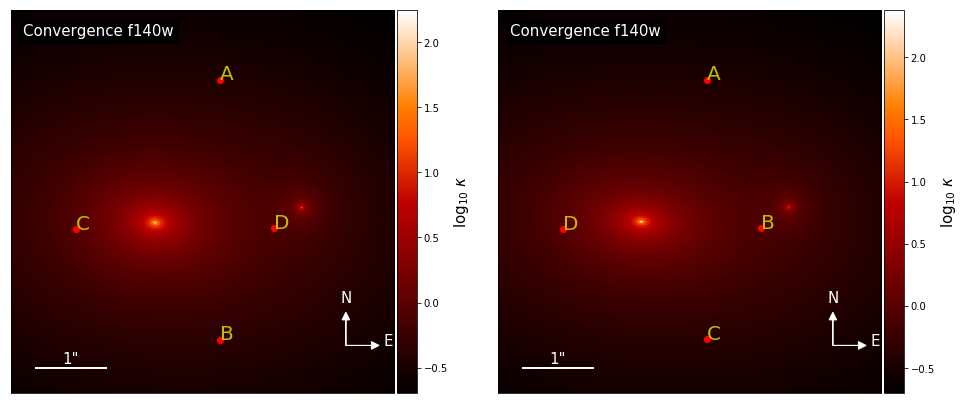

In [10]:
# Compare by eye the two
f, axes = plt.subplots(1, 2, figsize=(16, 8))
for i in range(2):
    axi = model_plots[i].my_convergence_plot(axes[i],alpha=1.,text=filters[i])
    model_plots[i].my_image_plot(axi,names=["A","D","B","C"],color="y")

for pth,flt in zip(paths,filters):
    plt.savefig(pth+"/compare_"+filters_str+".png")

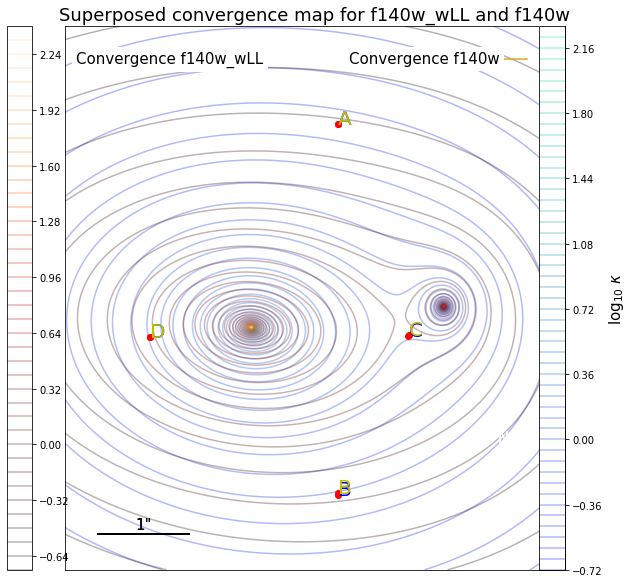

In [21]:
fsize=10
k = 50
f, axes = plt.subplots(1, 1, figsize=(fsize, fsize))
col = ["b","y"]
flipped = [False,True]
cmap = ["winter","gist_heat"]
for i,model in enumerate(model_plots):
    model.my_third_convergence_plot(axes,text=filters[i],alpha=.3,
                                      levels=k,
                                      flipped=flipped[i],
                                    cmap=cmap[i])
    model.my_image_plot(axes,names=["A","C","B","D"],color=col[i])
for i in range(len(kw_setting)):
    axes.scatter(*kw_setting[i]["kw_source"],color=col[i],marker="x")
    
axes.set_title("Superposed convergence map for "+filters[0]+" and "+filters[1],fontsize=18)
for pth,flt in zip(paths,filters):
    plt.savefig(pth+"conv_"+filters_str+".png")


In [ ]:
success(sys.argv[0])
exit()

In [32]:
# correct and plot the error
sig1 =[]
sig2 =[]

for i in range(len(sig_up_ra1)):
    sig1.append(sigma_rot(ra_image1[i],dec_image1[i],sig_up_ra1[i],sig_low_ra1[i], sig_up_dec1[i],sig_low_dec1[i],ra_image1[0],dec_image1[0], rot_matr1 ) )
    sig2.append(sigma_rot(ra_image2[i],dec_image2[i],sig_up_ra2[i],sig_low_ra2[i], sig_up_dec2[i],sig_low_dec2[i],ra_image2[0],dec_image2[0], rot_matr2 ) )

sig_rt_lens1 =np.array(sigma_rot(lens_ra1,lens_dec1,*sig_lens1,ra_image1[0],dec_image1[0],rot_matr1)) 
sig_rt_lens2 =sigma_rot(lens_ra2,lens_dec2,*sig_lens2,ra_image2[0],dec_image2[0],rot_matr2)
sig_rt_pert1 =sigma_rot(pert_ra1,pert_dec1,*sig_pert1,ra_image1[0],dec_image1[0],rot_matr1)
sig_rt_pert2 =sigma_rot(pert_ra2,pert_dec2,*sig_pert2,ra_image2[0],dec_image2[0],rot_matr2)


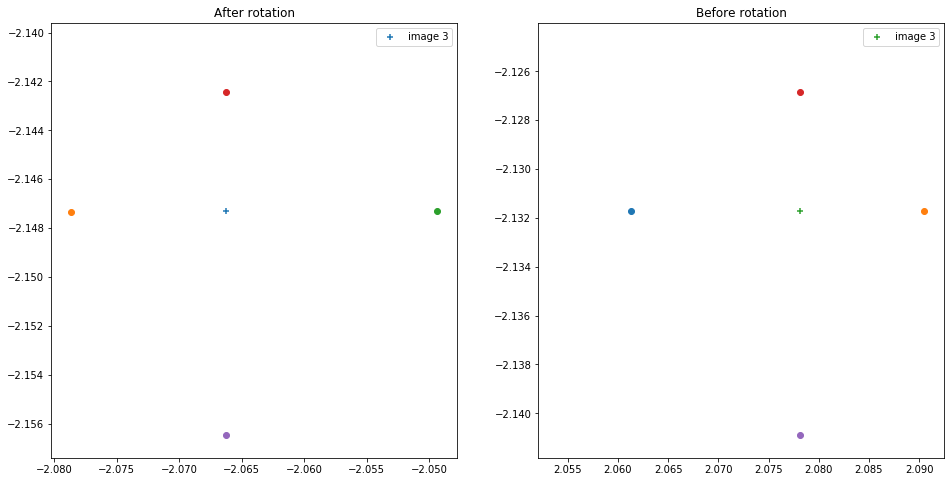

In [33]:
#Images error positions
image=3
fig,ax=plt.subplots(1, 2, figsize=(16, 8))
ax1=ax[0]
ax1.scatter(im_1[0][image],im_1[1][image],label="image "+str(image),marker="+")
ax1.scatter(*sig1[image][0])
ax1.scatter(*sig1[image][1])
ax1.scatter(*sig1[image][2])
ax1.scatter(*sig1[image][3])
ax1.set_title("After rotation")
ax1.legend()
ax2=ax[1]
x,y=ra_image1[i],dec_image1[i]
ax2.scatter(*[x-sig_low_ra1[i],y])
ax2.scatter(*[x+sig_up_ra1[i],y])
ax2.scatter(*[x,y],label="image "+str(image),marker="+")
ax2.scatter(*[x,y+sig_up_dec1[i]])
ax2.scatter(*[x,y-sig_low_dec1[i]])
ax2.set_title("Before rotation")
ax2.legend()

plt.show()


In [34]:
def plot_with_error(ax,x,y,sig,name,color):
    ax.scatter(x,y,label=name,marker="+",color=color)
    
    for k in range(len(sig)):
        ax1.scatter(*sig[k],color=color,marker=".")
        if k%2==0 and k!=len(sig):
            ax.plot([sig[k][0],sig[k+1][0]],
                [sig[k][1],sig[k+1][1]],color=color,linestyle="dashed")

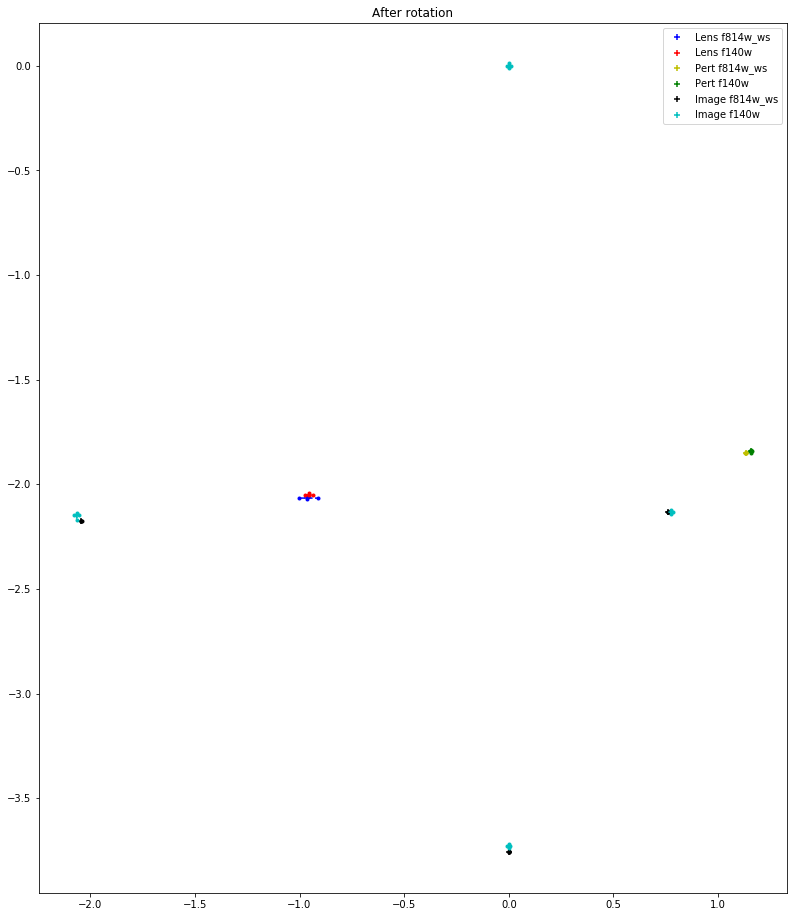

In [16]:
ig,ax=plt.subplots(1, 1, figsize=(16, 16))
ax1=ax
plot_with_error(ax,lens_ra_rot1,lens_dec_rot1,sig_rt_lens1,"Lens "+filter1,"b")
plot_with_error(ax,lens_ra_rot2,lens_dec_rot2,sig_rt_lens2,"Lens "+filter2,"r")
plot_with_error(ax,pert_ra_rot1,pert_dec_rot1,sig_rt_pert1,"Pert "+filter1,"y")
plot_with_error(ax,pert_ra_rot2,pert_dec_rot2,sig_rt_pert2,"Pert "+filter2,"g")
for i in range(len(sig1)):
    if i==0:
        plot_with_error(ax,im_1[0][i],im_1[1][i],sig1[i],"Image "+filter1,"k")
        plot_with_error(ax,im_2[0][i],im_2[1][i],sig2[i],"Image "+filter2,"c")
    else:
        plot_with_error(ax,im_1[0][i],im_1[1][i],sig1[i],"","k")
        plot_with_error(ax,im_2[0][i],im_2[1][i],sig2[i],"","c")
ax1.set_title("After rotation")
ax.set_aspect("equal")

ax1.legend()

plt.savefig(path1+"positions_"+filters+".png")
plt.savefig(path2+"positions_"+filters+".png")
plt.show()


## Also consider plotting the final position wrt the final position

In [21]:
A_in1 = [in_x1[0],in_y1[0]]
A_in2 = [in_x2[0],in_y2[0]]
B_in1 = [in_x1[index_B1],in_y1[index_B1]]
B_in2 = [in_x2[index_B2],in_y2[index_B2]]

in_rot_matr1 = find_new_rot(A_in1,B_in1,creat_matr=True)
in_rot_matr2 = find_new_rot(A_in2,B_in2,creat_matr=True)

#in_ra1,in_dec1 = rt_coord(in_x1-in_x1[0],in_y1-in_y1[0],in_rot_matr1)
#in_ra2,in_dec2 = rt_coord(in_x2-in_x2[0],in_y2-in_y2[0],in_rot_matr2)
in_ra1,in_dec1 = rt_coord(in_x1,in_y1,in_rot_matr1)
in_ra2,in_dec2 = rt_coord(in_x2,in_y2,in_rot_matr2)

in_im_1 = in_ra1,in_dec1
in_im_2 = in_ra2,in_dec2


in_lens_ra_rot1,in_lens_dec_rot1=rt_coord(in_lensx1,in_lensy1,in_rot_matr1)
in_pert_ra_rot1,in_pert_dec_rot1=rt_coord(in_pertx1,in_perty1,in_rot_matr1)

in_lens_ra_rot2,in_lens_dec_rot2=rt_coord(in_lensx2,in_lensy2,in_rot_matr2)
in_pert_ra_rot2,in_pert_dec_rot2=rt_coord(in_pertx2,in_perty2,in_rot_matr2)


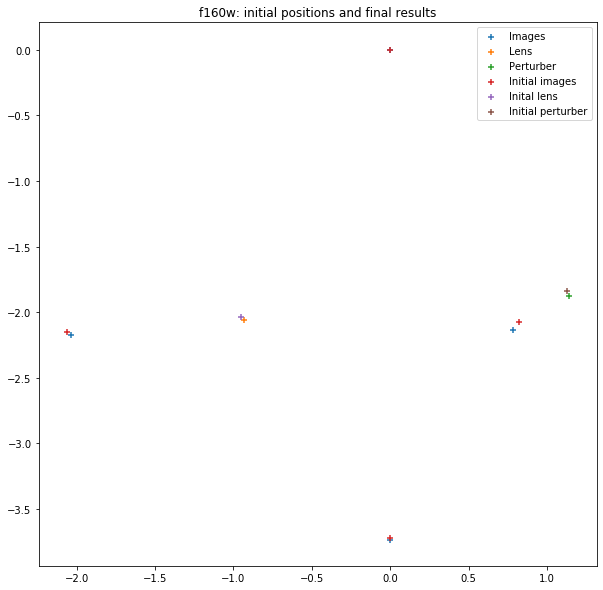

In [22]:
npix=10
f,ax =plt.subplots(1, 1, figsize=(npix,npix))
plt.title(filter1+": initial positions and final results")
ax.scatter(im_1[0],im_1[1],marker="+",label="Images")
ax.scatter(lens_ra_rot1,lens_dec_rot1,marker="+",label="Lens")
ax.scatter(pert_ra_rot1,pert_dec_rot1,marker="+",label="Perturber")
ax.scatter(in_im_1[0],in_im_1[1],marker="+",label="Initial images")
ax.scatter(in_lens_ra_rot1,in_lens_dec_rot1,marker="+",label="Inital lens")
ax.scatter(in_pert_ra_rot1,in_pert_dec_rot1,marker="+",label="Initial perturber")
plt.legend()
plt.show()


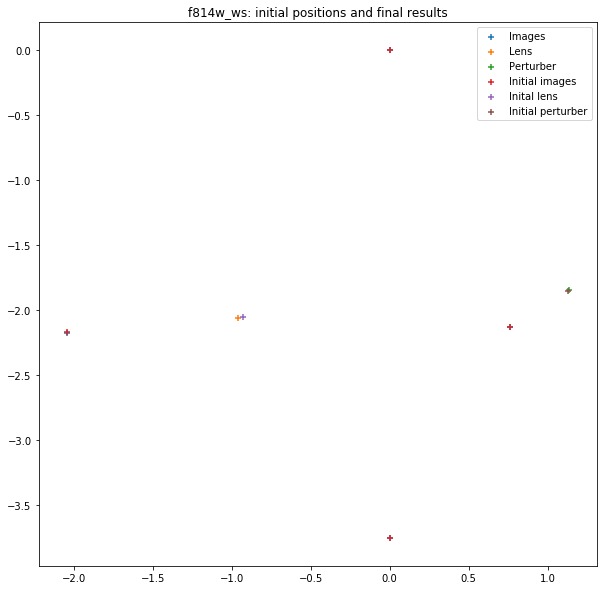

In [23]:
npix=10
f,ax =plt.subplots(1, 1, figsize=(npix,npix))
plt.title(filter2+": initial positions and final results")
ax.scatter(im_2[0],im_2[1],marker="+",label="Images")
ax.scatter(lens_ra_rot2,lens_dec_rot2,marker="+",label="Lens")
ax.scatter(pert_ra_rot2,pert_dec_rot2,marker="+",label="Perturber")
ax.scatter(in_im_2[0],in_im_2[1],marker="+",label="Initial images")
ax.scatter(in_lens_ra_rot2,in_lens_dec_rot2,marker="+",label="Inital lens")
ax.scatter(in_pert_ra_rot2,in_pert_dec_rot2,marker="+",label="Initial perturber")
plt.legend()
plt.show()

In [24]:
#########  not related to the overlap of models: I want to print the converted lens parameters from one filter to the other 
 # (considering the rotation and all)
def rt_coord(coord_ra,coord_dec,transf_m):
    try:
        if len(coord_dec)!=len(coord_ra):
            raise ValueError("coord_ra and coord_dec must have the same lenght!")
    except:
        coord_ra,coord_dec = [coord_ra],[coord_dec]
    theta = -np.arcsin(transf_m[0][1])
    rot_matrix = np.array([[np.cos(theta),-np.sin(theta)],[-np.sin(theta),-np.cos(theta)]])
    
    inv_matrix = -1*np.array([[-1,0],[0,-1]])
    if len(coord_ra)==1:
        return np.dot(np.dot([*coord_ra,*coord_dec],rot_matrix),inv_matrix)
    rt_ra,rt_dec = [] , []
    for ra,dec in zip(coord_ra,coord_dec):
        res = np.dot(np.dot([ra,dec],rot_matrix),inv_matrix)
        rt_ra.append(res[0])
        rt_dec.append(res[1])
    return np.array(rt_ra),np.array(rt_dec)

def find_new_rot(acoord,bcoord,creat_matr = False):
    dx = bcoord[0]-acoord[0]
    dy = bcoord[1]-acoord[1]
    intheta = np.arctan(dy/dx)
    theta = np.pi-(np.pi/2. - abs(intheta))*intheta/abs(intheta) 
    #theta = -(np.pi/2-intheta)
    if creat_matr==False:
        return theta
    else:
        return np.array([[np.cos(theta),-np.sin(theta)],[-np.sin(theta),-np.cos(theta)]])
Acoord1 = [ra_image1[0],dec_image1[0]]
Acoord2 = [ra_image2[0],dec_image2[0]]


#######################################################
###### this must be checked for each new model#########
index_B1 = 1
index_B2 = 1
Bcoord1 = [ra_image1[index_B1],dec_image1[index_B1]]
Bcoord2 = [ra_image2[index_B2],dec_image2[index_B2]]
#######################################################

rot_matr1 = find_new_rot(Acoord1,Bcoord1,creat_matr=True)
rot_matr2 = find_new_rot(Acoord2,Bcoord2,creat_matr=True)
inv_rot_matr2 = np.linalg.inv(rot_matr2)


ra1_,dec1_ = rt_coord(ra_image1-ra_image1[0],dec_image1-dec_image1[0],np.dot(in_rot_matr2,rot_matr1))




# Convert the lens parameters 
def conv_e12(e1,e2,transf_m):
    theta =  np.arcsin(transf_m[0][1]) #-1 cause "reflected" image
    #e1 = [(1-q)/(1+q)] cos2phi = alpha cos2phi
    #e2 = [(1-q)/(1+q)] sin2phi = alpha sin2phi
    alpha = np.sqrt(e1**2+e2**2)
    q = (1-alpha)/(1+alpha)
    phi=0.5 * np.arctan(e2/e1)
    phi_new= (phi-theta)
    e1_rot = alpha*np.cos(2*phi_new)
    e2_rot = alpha*np.sin(2*phi_new)
    return e1_rot,e2_rot

e1_rot1_,e2_rot1_ = conv_e12(kwargs_lens1[0]["e1"],kwargs_lens1[0]["e2"],rot_matr1)
e1_rot1_,e2_rot1_ = conv_e12(e1_rot1_,e2_rot1_,in_rot_matr2)
lens_ra1_,lens_dec1_ = kwargs_lens1[0]["center_x"],kwargs_lens1[0]["center_y"]
pert_ra1_,pert_dec1_ = kwargs_lens1[1]["center_x"],kwargs_lens1[1]["center_y"]

lens_ra_rot1_,lens_dec_rot1_=rt_coord(lens_ra1_-ra_image1[0],lens_dec1_-dec_image1[0],rot_matr1)
pert_ra_rot1_,pert_dec_rot1_=rt_coord(pert_ra1_-ra_image1[0],pert_dec1_-dec_image1[0],rot_matr1)

lens_ra_rot1_,lens_dec_rot1_=rt_coord(lens_ra_rot1_,lens_dec_rot1_,inv_rot_matr2)
pert_ra_rot1_,pert_dec_rot1_=rt_coord(pert_ra_rot1_,pert_dec_rot1_,inv_rot_matr2)

print(ra1_,dec1_)
print(lens_ra_rot1_,lens_dec_rot1_)
print(pert_ra_rot1_,pert_dec_rot1_)
print(e1_rot1_,e2_rot1_)

[ 0.         -1.50571617 -1.3598087   1.10559593] [0.         1.70426173 3.48407904 2.7618281 ]
1.4483738686197638 -1.7604887562349236
2.194559690730799 0.17617895146582727
0.20435962085620538 0.10387663303593839


In [53]:
psi1 = kwargs_lens1[2]["psi_ext"]

def conv_psi(psi,transf1,transf2):
    theta =  np.arcsin(transf1[0][1]) 
    antitheta = np.arcsin(transf2[0][1]) 
    psi_new = psi-theta +antitheta
    return psi_new
conv_psi(psi1,rot_matr1,rot_matr2)

-2.3982672913373704